In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import plot_model


In [2]:
img = np.load("/kaggle/input/tell-the-time/images.npy")
lbl = np.load('/kaggle/input/tell-the-time/labels.npy')


In [3]:
img = img.astype(float) / 255
img = np.expand_dims(img, -1)
input_shape = (150, 150, 1)

In [4]:
num_classes = 12
hours = keras.utils.to_categorical(lbl[:,0], num_classes)
minutes = lbl[:,1]/60

print(minutes[25])


0.016666666666666666


In [5]:
x_train, x_test, hours_train, hours_test, minutes_train, minutes_test = train_test_split(img, hours, minutes, train_size=0.8, random_state=23)

x_train, x_val, hours_train, hours_val, minutes_train, minutes_val = train_test_split(x_train, hours_train, minutes_train, test_size=0.125, random_state=23) # 0.125 * 0.8 = 0.1 

In [6]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, clock_val, hours_val, minutes_val, custom_metric):
        self.clock_val = clock_val
        self.hours_val = hours_val
        self.minutes_val = minutes_val
        self.custom_metric = custom_metric
        self.errors = []
        
    def on_epoch_end(self, epoch, logs=None):
        hours_out, minutes_out = self.model.predict(self.clock_val,batch_size = 16)
        
        error = custom_metric(hours_out, minutes_out, self.hours_val, self.minutes_val)
        
        self.errors.append(error)
        hours = np.int16(error/60)
        minutes = error - 60 * hours
        print(f"Error = hours:{hours}  minutes:{minutes}") 
        

    

2022-11-25 16:33:00.147704: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:33:00.264762: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:33:00.265577: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-25 16:33:00.267362: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

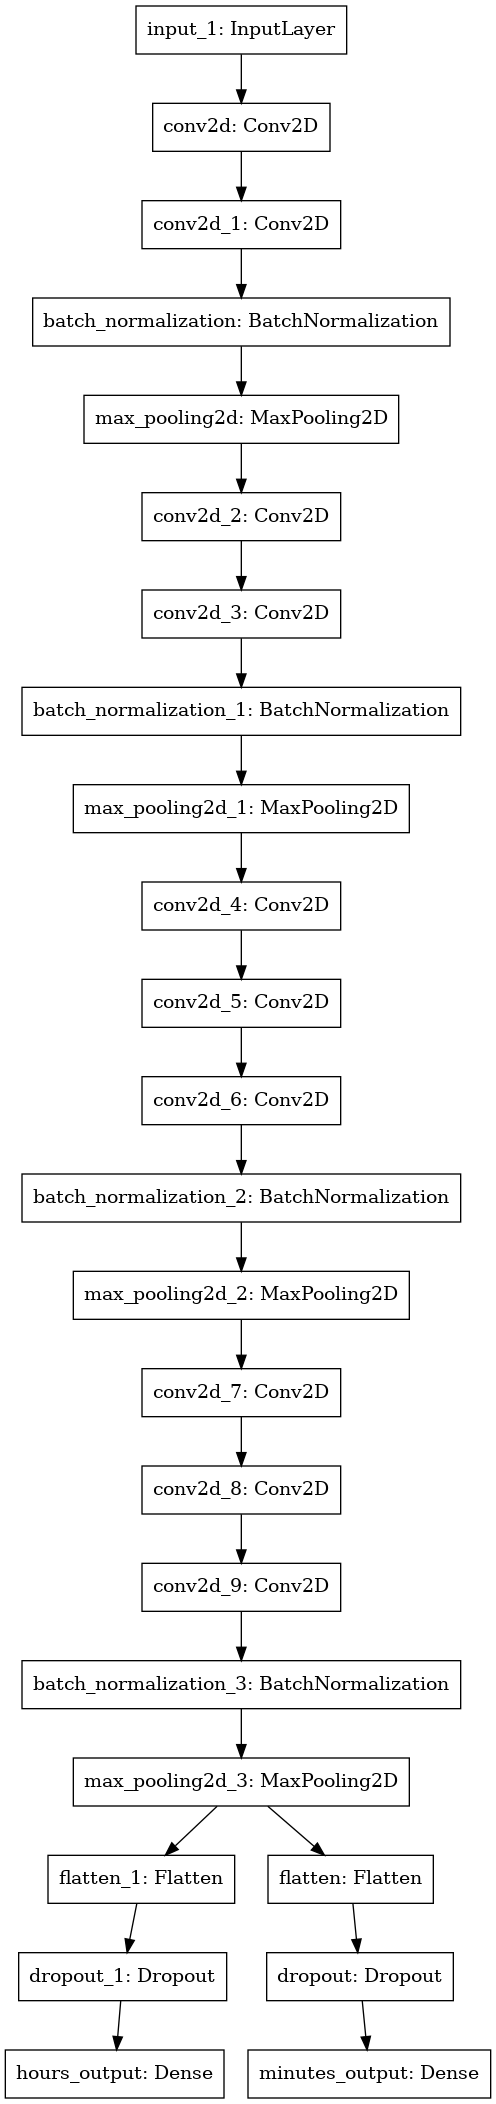

In [7]:
def create_convblock(filters, n, layer):
    for _ in range(n):
        layer = keras.layers.Conv2D(filters, kernel_size=(3, 3), activation='relu',padding='same')(layer)
    layer = tf.keras.layers.BatchNormalization()(layer)
    return layer

def create_model():
    input_layer = keras.layers.Input(shape=(input_shape))
    layer = create_convblock(32,2,input_layer)
    max_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(layer)
    layer = create_convblock(64,2,max_layer)
    max_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(layer)
    layer = create_convblock(128,3,max_layer)
    max_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(layer)
    layer = create_convblock(256,3,max_layer)
    split_layer = keras.layers.MaxPooling2D(pool_size=(2, 2))(layer)
    
    minutes_output = keras.layers.Flatten()(split_layer)
    minutes_output = keras.layers.Dropout(0.1)(minutes_output)
    minutes_output =  keras.layers.Dense(1, activation='sigmoid',name="minutes_output")(minutes_output)

    hours_output = keras.layers.Flatten()(split_layer)
    hours_output =  keras.layers.Dropout(0.1)(hours_output)
    hours_output =  keras.layers.Dense(num_classes, activation='softmax', name="hours_output")(hours_output)
    return  keras.Model(inputs=[input_layer],outputs=[hours_output,minutes_output])

model = create_model()
plot_model(model)

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 150, 150, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 150, 150, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 150, 150, 32) 128         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
# # compile models
model.compile(loss= {'hours_output': 'categorical_crossentropy', 'minutes_output': 'mse'},
            optimizer=keras.optimizers.Adam(learning_rate=0.001),
            metrics= {'hours_output': 'accuracy', 'minutes_output': 'mse'}
            )

In [10]:
def custom_metric(hours_out, minutes_out, hours_test, minutes_test):
    hour_out = np.argmax(hours_out, axis=1)
    minute_out = np.squeeze(minutes_out * 60)
    
    
    hour_test = np.argmax(hours_test, axis=1)
    minute_test = minutes_test * 60
    
    
    error_hour = np.abs(hour_test - hour_out)
    error_hour = np.array([x if x <= 6 else 12 - x for x in error_hour]) * 60
    
    error_minute = np.abs(minute_test - minute_out)
    error_minute = np.array([x if x <= 30 else 60 - x for x in error_minute])
    
    error = error_hour + error_minute
    
   
    
    return np.mean(error)

In [11]:
callback = CustomCallback(x_val, hours_val, minutes_val, custom_metric)
history = model.fit(x_train, [hours_train, minutes_train], epochs = 100,
        batch_size = 32,
        callbacks = [callback]
        )

2022-11-25 16:33:04.417236: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1134000000 exceeds 10% of free system memory.
2022-11-25 16:33:05.746493: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1134000000 exceeds 10% of free system memory.
2022-11-25 16:33:06.656595: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-11-25 16:33:08.547408: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


394/394 [==============================] - 26s 46ms/step - loss: 4.0416 - hours_output_loss: 3.7201 - minutes_output_loss: 0.3215 - hours_output_accuracy: 0.0830 - minutes_output_mse: 0.3215
Error = hours:3  minutes:14.87166666666667
Epoch 2/100
394/394 [==============================] - 18s 44ms/step - loss: 3.2272 - hours_output_loss: 2.9026 - minutes_output_loss: 0.3247 - hours_output_accuracy: 0.1137 - minutes_output_mse: 0.3247
Error = hours:3  minutes:4.671666666666255
Epoch 3/100
394/394 [==============================] - 17s 44ms/step - loss: 2.8359 - hours_output_loss: 2.5103 - minutes_output_loss: 0.3257 - hours_output_accuracy: 0.1417 - minutes_output_mse: 0.3257
Error = hours:2  minutes:48.67166734658369
Epoch 4/100
394/394 [==============================] - 18s 44ms/step - loss: 2.4518 - hours_output_loss: 2.3059 - minutes_output_loss: 0.1459 - hours_output_accuracy: 0.1811 - minutes_output_mse: 0.1459
Error = hours:2  minutes:40.24766590072048
Epoch 5/100
394/394 [=======

In [12]:
errors = np.array(callback.errors)
np.save("history.npy", history.history)
np.save("errors.npy", errors)
model.save_weights("weights")

In [13]:
# model.load_weights("/kaggle/working/weights.index")
hours_out, minutes_out = model.predict(x_test)

error = custom_metric(hours_out, minutes_out, hours_test, minutes_test)
print(error)
hours = np.int16(error/60)
minutes = error - 60 * hours
print(f"Error = hours:{hours}  minutes:{minutes}")

2022-11-25 17:05:30.379843: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 324000000 exceeds 10% of free system memory.
2022-11-25 17:05:30.752257: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 324000000 exceeds 10% of free system memory.


9.555617193621066
Error = hours:0  minutes:9.555617193621066
